# Example for NIRSpec IFU Data Reduction for J0759+1800
--------------------------------------------------------------------------------------------------------
**Latest update**: Jan 26, 2025.

** This Notebook uses: 
JWST science calibration pipeline https://github.com/spacetelescope/jwst
NSClean  https://science.nasa.gov/mission/webb/for-scientists/



## Set up

Import necessary packages and print the calibration pipeline version and current context.

In [1]:
import json
import logging
import os
import requests
import warnings

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip

import jwst
import nsclean
from jwst.datamodels import dqflags
from jwst.pipeline.calwebb_spec2 import Spec2Pipeline
from stpipe import crds_client

# hide all log and warning messages
logging.disable(logging.ERROR)
warnings.simplefilter('ignore', RuntimeWarning)

# print current jwst versions
print(f"JWST calibration pipeline version: {jwst.__version__}")
print(f"Current CRDS context: {crds_client.get_context_used('jwst')}")

JWST calibration pipeline version: 1.14.0
Current CRDS context: jwst_1322.pmap


Define a function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

Create a list of filenames. Download the data from MAST.

In [ ]:
# set up input and output directories
name = 'J0759+1800'
input_dir = '/mnt/ifu/quasar_4_6/'+name+'/'

# Point to where you want the output science results to go
#output_dir = 'reduced_level_2_onlystep3_stsci/'
output_dir = input_dir
output_dir0 = input_dir


dodet1=False
dospec2=True
dospec3=False


# Basic system utilities for interacting with files
import glob
import time
import shutil
import warnings
import zipfile
import urllib.request

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

#import jwst

from snowblind import SnowblindStep
from jwst.step import RampFitStep
from jwst.step import GainScaleStep


from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

from jwst.flatfield import FlatFieldStep


from jwst.associations import asn_from_list as afl
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

from jwst.associations.lib.rules_level2b import Asn_Lv2Spec

#output_dir0 = ''
# Output subdirectories to keep science data products organized
det1_dir = os.path.join(output_dir0, 'stage1/') # Detector1 pipeline outputs will go here
spec2_dir = os.path.join(output_dir, 'stage2/') # Spec2 pipeline outputs will go here
spec3_dir = os.path.join(output_dir, 'stage3/') # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)


In [ ]:

import subprocess

'''
move files
'''

f00cal = '/mnt/ifu/Downloads/MAST_'+name+'_JWST/JWST/*_cal.fits'
f00uncal = '/mnt/ifu/Downloads/MAST_'+name+'_JWST/JWST/*_uncal.fits'
f00rate = '/mnt/ifu/Downloads/MAST_'+name+'_JWST/JWST/*_rate.fits'

cc3 = 'cp '+f00cal+' '+output_dir0
cc2 = 'cp '+f00rate+' '+det1_dir
cc = 'cp '+f00uncal+' ./'


search_pattern = os.path.join(det1_dir,'rate.fits')
matching_files = glob.glob(search_pattern)
if matching_files:
    print("rate fits exist:")
    for file in matching_files:
        print(file)
else:
    result = subprocess.run(cc2, shell=True, capture_output=True, text=True)


search_pattern = os.path.join(spec2_dir,'cal.fits')
matching_files = glob.glob(search_pattern)
if matching_files:
    print("rate fits exist:")
    for file in matching_files:
        print(file)
else:
    result = subprocess.run(cc3, shell=True, capture_output=True, text=True)

search_pattern = os.path.join(det1_dir,'cal.fits')
matching_files = glob.glob(search_pattern)
if matching_files:
    print("cal fits exist:")
    for file in matching_files:
        print(file)
else:
    print("No cal file exist")



No cal file exist


In [ ]:
'''
Stage 1
'''

def rundet1(filename, outdir):
    print(filename)
    det1 = Detector1Pipeline() # Instantiate the pipeline
    det1.output_dir = outdir # Specify where the output should go

    # Overrides for whether or not certain steps should be skipped
    #det1.dq_init.skip = False
    #det1.saturation.skip = False
    #det1.firstframe.skip = False
    #det1.lastframe.skip = False
    #det1.reset.skip = False
    #det1.linearity.skip = False
    #det1.rscd.skip = False
    #det1.dark_current.skip = False
    #det1.refpix.skip = False
    #det1.jump.skip = False
    det1.ramp_fit.skip = False
    det1.gain_scale.skip = False

    # Bad pixel mask overrides
    #det1.dq_init.override_mask = 'myfile.fits'

    # Saturation overrides
    #et1.saturation.override_saturation = 'myfile.fits'

    # Reset overrides
    #det1.reset.override_reset = 'myfile.fits'

        # Linearity overrides
    #det1.linearity.override_linearity = 'myfile.fits'

    # RSCD overrides
    #det1.rscd.override_rscd = 'myfile.fits'

    # DARK overrides
    #det1.dark_current.override_dark = 'myfile.fits'

    # GAIN overrides
    #det1.jump.override_gain = 'myfile.fits'
    #det1.ramp_fit.override_gain = 'myfile.fits'

    # READNOISE overrides
    #det1.jump.override_readnoise = 'myfile.fits'
    #det1.ramp_fit.override_readnoise = 'myfile.fits'



    det1.save_results = True # Save the final resulting _rate.fits files

if dodet1:
    # Now let's look for input files of the form *uncal.fits from the science observation
    sstring = input_dir + 'jw*_*_*_nrs*_uncal.fits'
    lvl1b_files = sorted(glob.glob(sstring))
    print('Found ' + str(len(lvl1b_files)) + ' science input files to process')
    from snowblind import SnowblindStep
    from jwst.ramp_fitting import RampFitStep
    steps = {"jump": {"save_results": True,},"gain_scale": {"skip": True},"ramp_fit": {"skip": True}}
    
    k = 0
    for file0 in lvl1b_files:
        file = file0[:-11]
        print(file)
        dosnowblind = False
        if dosnowblind:
            Detector1Pipeline.call(file+"_uncal.fits", steps=steps)
            SnowblindStep.call(file+"_jump.fits", save_results=True, suffix="snowblind")
            rate, rateints = RampFitStep.call(file+"_snowblind.fits")
            cal = GainScaleStep.call(rate)
            rate.save(cal.meta.filename.replace("snowblind", "rate"))

            import os
            os.system("mv ./*rate.fits ./stage1/")
else:
    print('Skipping Detector1 processing')
    sstring = det1_dir + 'jw*_*_*_nrs*_rate.fits'
    print(sstring)
    lvl1b_files = sorted(glob.glob(sstring))



Skipping Detector1 processing
/mnt/ifu/quasar_4_6/J0759+1800/stage1/jw*_*_*_nrs*_rate.fits


In [ ]:
rate_names = []
cal_names = []


cc = False
if cc:
    for ifi0 in lvl1b_files:
        print(ifi0,'dsds')
        ifi = ifi0[:-11]
        ifi1 = ifi0[:31]
        ifi2 = ifi0[31:-11]
        rate_names.append(ifi1+'stage1/'+ifi2+'_rate.fits')
        cal_names.append(ifi1+ifi2+'_cal.fits')
else:
    rate_names = lvl1b_files
    for ifi0 in lvl1b_files:
        ifi = ifi0[-40:-10]

        cal_names.append(input_dir+ifi+'_cal.fits')    
print(rate_names[0])
print(cal_names)


/mnt/ifu/quasar_4_6/J0759+1800/stage1/jw03428005001_02101_00001_nrs1_rate.fits
['/mnt/ifu/quasar_4_6/J0759+1800/jw03428005001_02101_00001_nrs1_cal.fits', '/mnt/ifu/quasar_4_6/J0759+1800/jw03428005001_02101_00001_nrs2_cal.fits', '/mnt/ifu/quasar_4_6/J0759+1800/jw03428005001_02101_00002_nrs1_cal.fits', '/mnt/ifu/quasar_4_6/J0759+1800/jw03428005001_02101_00002_nrs2_cal.fits']


## Create a mask from a calibrated file

The goal in creating the mask is to identify any pixel that is unilluminated.  That is, the mask must contain True and False values, where True indicates that the pixel is dark, and False indicates that the pixel is illuminated (not dark).

Here, we mark the following detector areas as illuminated, non-dark areas (False):

- pixels designated as science areas for IFU data
- traces from failed-open MSA shutters
- 5-sigma outliers
- any pixel set to NaN in the rate data.

To tune the outlier detection in this mask, try modifying the n_sigma parameter below.  A higher value will identify fewer outliers. A lower value will identify more.

Create and save a mask identifying dark areas of the detector.

In [9]:
# scale parameter for identifying outliers
n_sigma = 5.0

# loop over rate files and cal files together
mask_names = []
for rate_file, cal_file in zip(rate_names, cal_names):
    
    # copy SCI data from rate file
    with fits.open(rate_file) as hdul:
        rate_sci = hdul['SCI'].data.copy()

    # copy DQ data from cal file
    with fits.open(cal_file) as hdul:
        cal_dq = hdul['DQ'].data.copy()

    # initialize mask with everything set to False
    mask = np.full(np.shape(cal_dq), False)

    # find non-science pixels and set them to True
    dark = np.where(cal_dq & dqflags.pixel['NON_SCIENCE'])
    mask[dark] = True

    # find traces of failed open shutters and set them to False
    fail_open = np.where(cal_dq & dqflags.pixel['MSA_FAILED_OPEN'])
    mask[fail_open] = False

    # find NaNs from the rate file
    # set them to 0 in the rate data and False in the mask
    is_nan = np.isnan(rate_sci)
    rate_sci[is_nan] = 0
    mask[is_nan] = False

    # ignore the entire fixed slit area:
    # set it to False in the mask
    mask[922:1116, :] = False

    # keep the reference pixel columns (first and last 4)
    mask[:, :5] = True
    
    # keep one extra column on the right, since it is always empty for NRS1
    mask[:, -5:] = True

    # get clipped stats to flag n-sigma outliers and ignore them in the mask
    _, med, sig = sigma_clipped_stats(rate_sci, mask=~mask, mask_value=0, sigma=5.0)
    outliers = np.where(rate_sci > med + n_sigma * sig)
    mask[outliers] = False

    # save the mask to disk
    outname = rate_file.replace('rate', 'mask')
    fits.writeto(outname, mask.astype(np.uint8), overwrite=True)
    print(f"Saved {outname}") 

    mask_names.append(outname)

Saved /mnt/ifu/quasar_4_6/J0759+1800/stage1/jw03428005001_02101_00001_nrs1_mask.fits
Saved /mnt/ifu/quasar_4_6/J0759+1800/stage1/jw03428005001_02101_00001_nrs2_mask.fits
Saved /mnt/ifu/quasar_4_6/J0759+1800/stage1/jw03428005001_02101_00002_nrs1_mask.fits
Saved /mnt/ifu/quasar_4_6/J0759+1800/stage1/jw03428005001_02101_00002_nrs2_mask.fits


## Verify the mask keeps only unilluminated data

Check the mask against the rate data to make sure it keeps only dark areas of the detector.

In this example, note that there are still some remaining illuminated areas, primarily due to transient artifacts like cosmic rays and snowballs.

Plot the rate data with masked areas blocked.

In [10]:
# define a helper function for data plotting

def plot_dark_data(rate_file, mask_file):

    # make a matplotlib figure
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    plt.suptitle(f'Dark areas for {os.path.basename(rate_file)}')

    # open the mask and science data
    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data

    with fits.open(rate_file) as hdulist:
        sci = hdulist['SCI'].data

    # get data limits from the dark data
    masked_sci = sci.copy()
    masked_sci[mask == 0] = 0
    vmin = np.nanpercentile(masked_sci, 1)
    vmax = np.nanpercentile(masked_sci, 99)

    # plot the science image with limits from the dark data
    sci[np.isnan(sci)] = 0
    ax[0].imshow(sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[0].set_title('Rate data')

    # plot the mask: values are 1 or 0
    ax[1].imshow(mask, origin='lower', vmin=0, vmax=1)
    ax[1].set_title('Mask')

    # plot the dark data with the same limits as the science data
    ax[2].imshow(masked_sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[2].set_title('Dark data')

    fig.tight_layout()

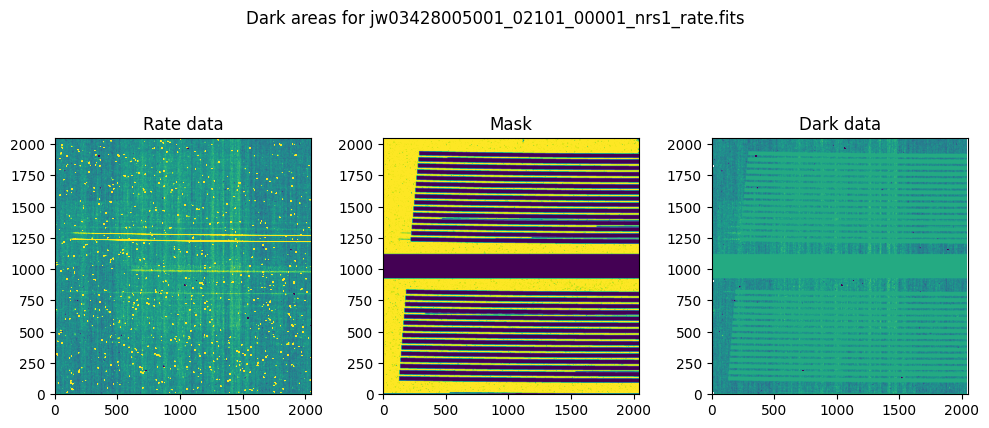

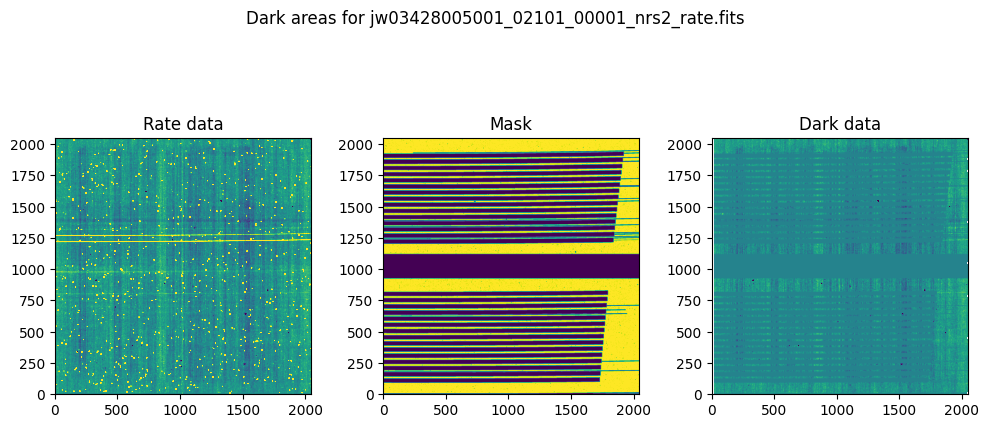

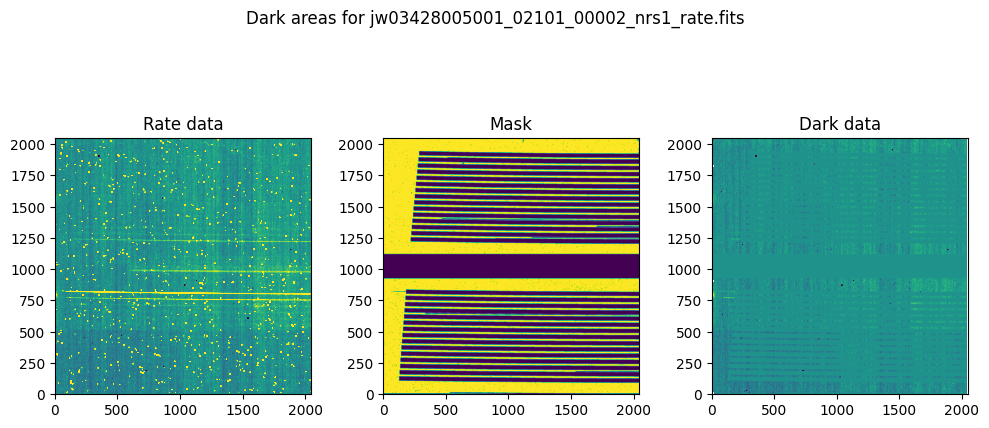

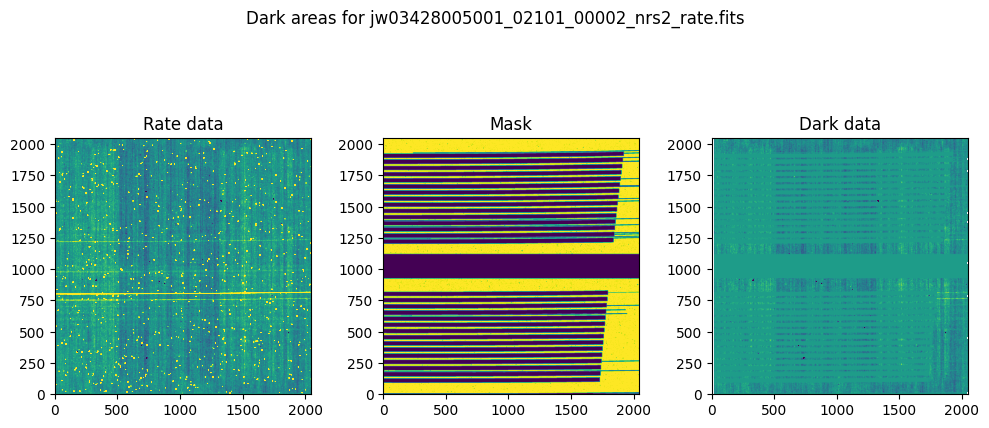

In [11]:
# plot each associated set of rate data and mask file
for rate_file, mask_file in zip(rate_names, mask_names):
    plot_dark_data(rate_file, mask_file)

## Use the mask to clean the rate data

We can now use the NSClean package with the created mask to update the rate data, removing residual noise.

In some situations, the cleaning step may fail to find a fit to the background noise.  In the cell below, the error from the failure is caught and a "Cannot clean" message is shown for the file instead.

This failure may occur if the mask does not contain enough dark data (marked True).  In particular, every column in the mask except for the first and last 4 columns must contain some pixels marked True.  The background fitting procedure considers each column, one at a time, so it will crash if there is no data in a column to fit.

If you're getting error messages from the step below, check that your mask in the image above has at least some True values in every column.

For each file, instantiate the cleaner with the mask, then call the clean function.

In [12]:
# define a helper function to clean each file

def clean(rate_file, mask_file, suffix='rate_cleaned'):
    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data.astype(bool)

    rate_hdulist = fits.open(rate_file)
    sci = rate_hdulist['SCI'].data
    detector = rate_hdulist[0].header['DETECTOR']

    # set NaN values to zero
    is_nan = np.isnan(sci)
    sci[is_nan] = 0

    # instantiate the cleaner
    cleaner = nsclean.NSClean(detector, mask)

    # clean the data
    try:
        cleaned_sci = cleaner.clean(sci)
    except np.linalg.LinAlgError:
        print(f'Cannot clean {os.path.basename(rate_file)}')
        return None
    
    # restore NaNs
    cleaned_sci[is_nan] = np.nan  # restore NANs

    # save result
    rate_hdulist['SCI'].data = cleaned_sci

    outname = rate_file.replace('rate', suffix)
    rate_hdulist.writeto(outname, overwrite=True)
    rate_hdulist.close()
    print(f'Saved {os.path.basename(outname)}')
    
    return outname

In [13]:
# clean each rate file with its associated mask

cleaned_rate_names = []
for rate_file, mask_file in zip(rate_names, mask_names):
    outname = clean(rate_file, mask_file)
    cleaned_rate_names.append(outname)

Saved jw03428005001_02101_00001_nrs1_rate_cleaned.fits
Saved jw03428005001_02101_00001_nrs2_rate_cleaned.fits
Saved jw03428005001_02101_00002_nrs1_rate_cleaned.fits
Saved jw03428005001_02101_00002_nrs2_rate_cleaned.fits


In [14]:
# #run stage 2 and 3
# import subprocess
# #os.sys('python reproject_nirspec_emsm1134_snowblind.py')
# try:
#     subprocess.run(["python", "reduce_jw1134_snowblind.py"], check=True)
#     print("Reprojection script executed successfully.")
# except subprocess.CalledProcessError as e:
#     print(f"Error: Reprojection script failed with exit code {e.returncode}.")

In [ ]:
import sys,os, pdb

sys.path.append('/mnt/ifu/Downloads/reproject_combine_JWST-main/source')
sys.path.append('/mnt/ifu/ifu_script')
import make_mask_nirspec_v2 as make_mask_nirspec


# Science processing

dobadpxlmsk = {'mask_high': 1e99,'mask_negative':-10,'run_spec2' : 'True'}


# Basic system utilities for interacting with files
import glob
import time
import shutil
import warnings
import zipfile
import urllib.request

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots




'''
Run Stage 2
'''


def runspec2(filename, outdir):
#    spec2 = Spec2Pipeline()
    crds_config = Spec2Pipeline.get_config_from_reference(filename)
    spec2 = Spec2Pipeline.from_config_section(crds_config)
    spec2.output_dir = outdir
    print(outdir)
    spec2.cube_build.weighting = 'emsm'
    spec2.cube_build.scale1 = 0.1 # Output cube spaxel scale (arcsec) in dimension 1 if setting it by hand
    spec2.cube_build.scale2 = 0.1 # Output cube spaxel scale (arcsec) in dimension 2 if setting it by hand



    spec2.imprint_subtract.skip = True
    spec2.save_results = True

    spec2(filename)

sstring = det1_dir + 'jw*_*_*_nrs*_rate_cleaned.fits'
ratefiles = sorted(glob.glob(sstring))
ratefiles=np.array(ratefiles)
print('Found ' + str(len(ratefiles)) + ' input files to process')
#
#No leakcal sub
if dospec2:
    for file in ratefiles:
        runspec2(file, spec2_dir)
if dobadpxlmsk:
    for nrs in [1,2]:
        sci_cals = spec2_dir + 'jw*_*_*_nrs'+str(nrs)+'*_cleaned_cal.fits'
        #sci_cals = spec2_dir + '/jw*_*_*_nrs'+str(nrs)+'_cal.fits'
        sci_cal  = sorted(glob.glob(sci_cals))
        sci_cal = np.array(sci_cal)
        print('Found ' + str(len(sci_cal)) + ' input files to process')
        #breakpoint()
        spec2_masked_dir = os.path.join(output_dir, 'stage2_masked/') # Spec2 pipeline outputs will go here
        if not os.path.exists(spec2_masked_dir):
            os.makedirs(spec2_masked_dir)

        mask_high = dobadpxlmsk['mask_high']
        mask_negative = dobadpxlmsk['mask_negative']
        run_spec2 = dobadpxlmsk['run_spec2']
        make_mask_nirspec.make_mask(sci_cal,spec2_masked_dir,mask_high = mask_high,mask_negative = mask_negative,run_spec2=run_spec2)

    spec2_dir = spec2_masked_dir #update spec2_dir

else:
    print('Skipping Spec2 processing')



def writel2asn(scifiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles,rule=Asn_Lv2Spec,product_name=prodname)
    #leakpath = '/home/wzliu/J1007/data/jw01764007001_05101_00001_nrs'

    # Add leakcal files to the association if needed
    for i in np.arange(0,len(asn["products"])):
        if 'nrs1' in asn["products"][i]['name']:
            asn["products"][i]['members'].append({'expname': leakcalexpnr1, 'exptype': 'imprint'})
        if 'nrs2' in asn["products"][i]['name']:
            asn["products"][i]['members'].append({'expname': leakcalexpnr2, 'exptype': 'imprint'})

    asn["asn_type"] = "spec2"
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)





def writel3asn(scifiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

sci_cals = spec2_dir + '*nrs*_cal.fits'
sci_cal  = sorted(glob.glob(sci_cals))
sci_cal =np.array(sci_cal)
print('Found ' + str(len(sci_cal)) + ' input files to process')

'''
Stage 3: generate final data cubes

'''

def runspec3(filename,weightname='emsm',spxsize=0.05):
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference(filename)
    #spec3 = Spec3Pipeline.from_config_section()
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    spec3.outlier_detection.skip = False
    spec3.output_dir = spec3_dir
    spec3.save_results = True


    # Cube building configuration options
    # spec3.cube_build.output_file = 'bandcube' # Custom output name
    # spec3.cube_build.output_type = 'band' # 'band', 'channel', or 'multi' type cube output
    # spec3.cube_build.channel = '1' # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
    #spec3.cube_build.weighting = 'drizzle'
    spec3.cube_build.weighting = weightname
    #spec3.cube_build.weighting = 'emsm' # 'emsm' or 'drizzle'
    #spec3.imprint_subtract.skip = True
    #spec3.cube_build.roiw = 0.015
    #spec3.cube_build.weighting = 'emsm'
    #spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'
    spec3.cube_build.coord_system = 'skyalign'
    spec3.cube_build.scalexy = spxsize # Output cube spaxel scale (arcsec) in dimension 1 if setting it by hand
    #spec3.cube_build.scale2 = spxsize # Output cube spaxel scale (arcsec) in dimension 2 if setting it by hand
    # spec3.cube_build.scalew = 0.002 # Output cube spaxel size (microns) in dimension 3 if setting it by hand

    # Overrides for whether or not certain steps should be skipped
    #spec3.assign_mtwcs.skip = False
    #spec3.master_background.skip = True
    #spec3.outlier_detection.skip = True
    #spec3.mrs_imatch.skip = True
    #spec3.cube_build.skip = False
    #spec3.extract_1d.skip = False

    # Cubepar overrides
    #spec3.cube_build.override_cubepar = 'myfile.fits'

    # Extract1D overrides
    #spec3.extract1d.override_extract1d = 'myfile.asdf'
    #spec3.extract1d.override_apcorr = 'myfile.asdf'
#    spec3.outlier_detection.snr = '5.0 4.0'
#    spec3.outlier_detection.scale = '2.0 1.7'
#    spec3.outlier_detection.nhigh = 5e11
    s=spec3(filename)
    return s



asnfile=os.path.join(spec3_dir, 'l3asn.json')
weightname = 'drizzle'
spxsize = 0.1

if dospec3:
    print(spxsize)
    writel3asn(sci_cal, asnfile, name+'_'+weightname+'_jw1140_Level3_p'+str(spxsize))
    s=runspec3(asnfile,weightname,spxsize)
if subbkg:
    s3dfits = name+'_'+weightname+'_jw1140_Level3_p'+str(int(spxsize))+'_s3d'
    sub_bkg(s3dfits,fp=spec3_dir)




Found 4 input files to process
/mnt/ifu/quasar_4_6/J0759+1800/stage2/
/mnt/ifu/quasar_4_6/J0759+1800/stage2/


KeyboardInterrupt: 